# Forecasting CNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024
Updated: 02/20/2025

This script:
1. Opens the CSV files with the CFS forecasts. 
2. Runs the forecast through the trained Gaussian Process model. 
3. Produces an ensemble of RNBS forecasts for each of the Great Lakes.
4. Saves the forecast to a CSV file.
5. Creates a timeseries plot and saves it as a PNG file. 

This script needs the following files:

- input
    - GL_mask.nc
    - GP_trained_model.joblib
    - x_scaler.joblib
    - y_scaler.joblib
- data
    - CFS_EVAP_forecasts_Avgs_MM.csv
    - CFS_PCP_forecasts_Avgs_MM.csv
    - CFS_TMP_forecasts_Avgs_K.csv

In [207]:
import pandas as pd
from datetime import datetime
import joblib
import calendar
import matplotlib.pyplot as plt

User Input

In [208]:
# This is the directory where you cloned the repo
path_to_repo = '/Users/fitzpatrick/Desktop/'

# Path to download data to
dir = path_to_repo + 'cnbs-predictor-1/data/input/'

# Read in the CSVs
tmp_csv = dir + 'CFS_TMP_forecasts_Avgs_K.csv'
evap_csv = dir + 'CFS_EVAP_forecasts_Avgs_MM.csv'
pcp_csv = dir + 'CFS_PCP_forecasts_Avgs_MM.csv'

# Open the trained model(s)
GP_model = joblib.load(dir + 'GP_trained_model.joblib')
LR_model = joblib.load(dir + 'LR_trained_model.joblib')
RF_model = joblib.load(dir + 'RF_trained_model.joblib')
NN_model = joblib.load(dir + 'NN_trained_model.joblib')


# Define Functions

Determine the mean/median, min, and max RNBS values for each month from the ensemble members.

In [209]:
def calculate_median_confidence(df,lake):
    median = df.groupby(['year', 'month'])[lake].median().reset_index()

    # Calculate the 2.5th and 97.5th percentiles for the confidence band
    lower_bound = df.groupby(['year', 'month'])[lake].quantile(0.025).reset_index()
    upper_bound = df.groupby(['year', 'month'])[lake].quantile(0.975).reset_index()

    return median, lower_bound, upper_bound

Calculate the number of seconds in a month based on the month and the year. This is used to calculate units between cms and mm.

In [210]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

Convert a dataframe in [cms] to [mm].

In [211]:
def convert_cms_to_mm(df_cms):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_mm = df_cms.copy()

    sa_sup = 82097*1000000
    sa_mih = (57753 + 5956)*1000000
    sa_eri = 25655*1000000
    sa_ont = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_mm['seconds'] = df_mm.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_cms / surface_area * seconds_in_a_month = m * 1000 = mm
    for column in df_mm.columns:
        if column.startswith("eri"):
            df_mm[column] = df_mm[column] / sa_eri * df_mm['seconds'] * 1000
        elif column.startswith("sup"):
            df_mm[column] = df_mm[column] / sa_sup * df_mm['seconds'] * 1000
        elif column.startswith("mih"):
            df_mm[column] = df_mm[column] / sa_mih * df_mm['seconds'] * 1000
        elif column.startswith("ont"):
            df_mm[column] = df_mm[column] / sa_ont * df_mm['seconds'] * 1000

    # Deleting column 'seconds'
    df_mm.drop('seconds', axis=1)

    return df_mm

In [212]:
def convert_mm_to_cms(df_mm):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_cms = df_mm.copy()

    sa_sup = 82097*1000000
    sa_mih = (57753 + 5956)*1000000
    sa_eri = 25655*1000000
    sa_ont = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_cms['seconds'] = df_cms.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_mm / 1000 [to convert to m] * surface_area / seconds_in_a_month
    for column in df_mm.columns:
        if column.startswith("eri"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_eri) / df_cms['seconds']
        elif column.startswith("sup"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_sup) / df_cms['seconds']
        elif column.startswith("mih"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_mih) / df_cms['seconds']
        elif column.startswith("ont"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_ont) / df_cms['seconds']

    # Deleting column 'seconds'
    df_cms.drop('seconds', axis=1)

    return df_cms

Before plotting, we can remove any forecasts that are from previous months that have passed and only look at the future months forecasts.
If the current day is later than the 26th day of the month, the first forecast month needs to be the next month. This was a request by USACE.

In [213]:
def filter_predictions(df_y_pred):
    current_day = datetime.now().day
    current_month = datetime.now().month
    current_year = datetime.now().year

    # Determine filtering condition based on the day of the month
    if current_day >= 26:
        # Remove this month and all previous months
        filtered_y_pred = df_y_pred[
            (df_y_pred['year'] > current_year) |
            (df_y_pred['year'] == current_year) & (df_y_pred['month'] > current_month)
        ]
        print(f"First month forecast: {current_month+1}")
    else:
        # Keep this month
        filtered_y_pred = df_y_pred[
            (df_y_pred['year'] > current_year) |
            ((df_y_pred['year'] == current_year) & (df_y_pred['month'] >= current_month))
        ]
        print(f"First month forecast: {current_month}")
    return filtered_y_pred

In [219]:
def format_pred(y_pred_scaled):
    # Inverse transform y_pred_scaled and convert to dataframe with column names
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    df_y_pred = pd.DataFrame(y_pred, columns=['sup_evap', 'sup_pcp', 'sup_rnoff',
                                              'eri_evap', 'eri_pcp', 'eri_rnoff',
                                              'ont_evap', 'ont_pcp', 'ont_rnoff',
                                              'mih_evap', 'mih_pcp', 'mih_rnoff'])

    # Add back the columns with cfs_run, forecast_year, forecast_month, and convert all in one step
    df_y_pred[['cfs_run', 'year', 'month']] = pcp_data[['cfs_run', 'forecast_year', 'forecast_month']].astype(int)

    # Calculate CNBS for all lakes in one step (vectorized)
    for lake in ['sup', 'eri', 'ont', 'mih']:
        df_y_pred[f'{lake}_cnbs'] = df_y_pred[f'{lake}_pcp'] + df_y_pred[f'{lake}_rnoff'] - df_y_pred[f'{lake}_evap']

    # Reorder columns to move 'cfs_run', 'year', 'month' to the left
    df_y_pred = df_y_pred[['cfs_run', 'year', 'month'] + [col for col in df_y_pred.columns if col not in ['cfs_run', 'year', 'month']]]

    return df_y_pred

# Begin Script

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [215]:
## Read in PCP data from CFSR [mm]
pcp_data = pd.read_csv(pcp_csv,sep=',')

## Read in EVAP data from CFSR [mm]
evap_data = pd.read_csv(evap_csv,sep=',')

## Read in TMP data from CFSR [K]
tmp_data = pd.read_csv(tmp_csv,sep=',')

In [216]:
X = pd.DataFrame({
    'sup_pcp_w': pcp_data['sup_lake'],
    'eri_pcp_w': pcp_data['eri_lake'],
    'ont_pcp_w': pcp_data['ont_lake'],
    'mih_pcp_w': pcp_data['mih_lake'],
    'sup_pcp_l': pcp_data['sup_land'],
    'eri_pcp_l': pcp_data['eri_land'],
    'ont_pcp_l': pcp_data['ont_land'],
    'mih_pcp_l': pcp_data['mih_land'],
    'sup_evap_w': evap_data['sup_lake'],
    'eri_evap_w': evap_data['eri_lake'],
    'ont_evap_w': evap_data['ont_lake'],
    'mih_evap_w': evap_data['mih_lake'],
    'sup_evap_l': evap_data['sup_land'],
    'eri_evap_l': evap_data['eri_land'],
    'ont_evap_l': evap_data['ont_land'],
    'mih_evap_l': evap_data['mih_land'],
    'sup_tmp_w': tmp_data['sup_lake'],
    'eri_tmp_w': tmp_data['eri_lake'],
    'ont_tmp_w': tmp_data['ont_lake'],
    'mih_tmp_w': tmp_data['mih_lake'],
    'sup_tmp_l': tmp_data['sup_land'],
    'eri_tmp_l': tmp_data['eri_land'],
    'ont_tmp_l': tmp_data['ont_land'],
    'mih_tmp_l': tmp_data['mih_land']
})

Standardize the data

In [217]:
# Standardize the data
x_scaler = joblib.load(dir + 'x_scaler.joblib')
y_scaler = joblib.load(dir + 'y_scaler.joblib')
X_scaled = x_scaler.transform(X)

In [235]:
y_filtered_model = {}

# List of models and their corresponding names
model_dict = {
    'GP': GP_model,
    'LR': LR_model,
    'RF': RF_model,
    'NN': NN_model
}

# Loop through each model and process the predictions
for model_name, model in model_dict.items():
    # Step 1: Predict scaled values
    y_pred_scaled = model.predict(X_scaled)

    # Step 2: Format the predictions
    y_pred = format_pred(y_pred_scaled)

    # Step 3: Filter predictions
    y_filtered = filter_predictions(y_pred)
    y_filtered_model[model_name] = pd.DataFrame(y_filtered)

    # Step 4: Save filtered predictions as CSV
    y_filtered.to_csv(f'{dir}CNBS_forecasts_mm_{model_name}.csv', sep=',', index=False)

    # Step 5: Convert mm to cms
    df_y_cms = convert_mm_to_cms(y_filtered)

    # Step 6: Save the converted predictions as CSV
    df_y_cms.to_csv(f'{dir}CNBS_forecasts_cms_{model_name}.csv', sep=',', index=False)

First month forecast: 3
First month forecast: 3
First month forecast: 3
527/527 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step
First month forecast: 3


In [236]:
print(y_filtered_dict)

{'GP':           cfs_run  year  month   sup_evap    sup_pcp  sup_rnoff    eri_evap  \
5958   2024052700  2025      3  75.806277  32.200165  34.020017   48.945064   
5969   2024052706  2025      3  68.278526  38.939779  34.523193   47.164196   
5980   2024052712  2025      3  81.046522  59.006167  40.149543   70.828562   
5991   2024052718  2025      3  78.326629  27.941156  29.050775   36.472778   
6002   2024052800  2025      3  71.277291  32.023668  32.867610   44.811858   
...           ...   ...    ...        ...        ...        ...         ...   
16856  2025021918  2025      7  24.188639  97.244904  44.903424  111.619826   
16857  2025021918  2025      8  33.034324  64.819222  35.122647  119.198953   
16858  2025021918  2025      9  56.707276  78.019463  47.626460  120.078887   
16859  2025021918  2025     10  63.504506  68.832120  48.878387   93.120045   
16860  2025021918  2025     11  70.246429  92.292035  44.259553   74.502571   

          eri_pcp   eri_rnoff   ont_evap    

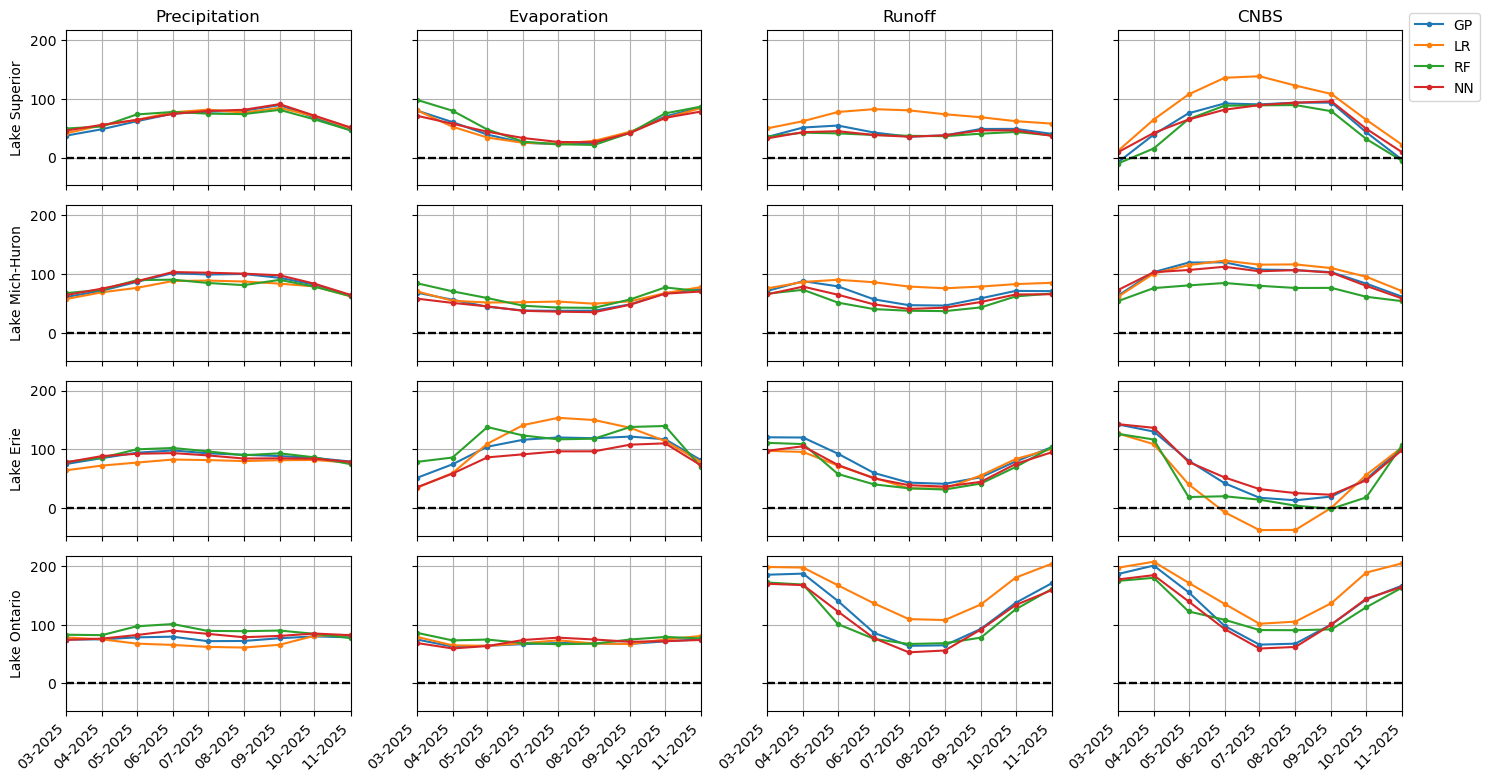

In [231]:
models = ['GP', 'LR', 'RF', 'NN']

# List of datasets
datasets = [y_filtered_model[model] for model in models]

# Columns of interest
columns = ['sup_pcp', 'sup_evap', 'sup_rnoff', 'sup_cnbs',
           'mih_pcp', 'mih_evap', 'mih_rnoff', 'mih_cnbs',
           'eri_pcp', 'eri_evap', 'eri_rnoff', 'eri_cnbs',
           'ont_pcp', 'ont_evap', 'ont_rnoff', 'ont_cnbs']

# Create a 1x4 subplot grid
fig, axs = plt.subplots(4, 4, figsize=(15, 8))

global_y_min, global_y_max = float('inf'), float('-inf')  # Initialize to extremes

# Group data by 'year' and 'month' once for each dataset
grouped_datasets = {
    model: dataset.groupby(['year', 'month']).median().reset_index()
    for model, dataset in zip(models, datasets)
}

# Loop over the columns and plot the medians for each dataset
for i, column in enumerate(columns):
    row = i // 4  # Row index (integer division by 4)
    col = i % 4   # Column index (remainder after division by 4)

    for dataset_index, model in enumerate(models):
        # Get the grouped DataFrame for the current model
        median_df = grouped_datasets[model]

        # Add a 'date' column to the median DataFrame
        median_df['date'] = pd.to_datetime(median_df[['year', 'month']].assign(day=1))

        # Plot the medians for the current dataset on the same subplot
        axs[row, col].plot(median_df['date'], median_df[column], marker='o', markersize=3, label=model)
        axs[row, col].axhline(0, color='black', linestyle='--')
        axs[row, col].grid(True)

        # Update the global y-axis limits based on the current dataset
        current_y_min = median_df[column].min()
        current_y_max = median_df[column].max()
        global_y_min = min(global_y_min, current_y_min)
        global_y_max = max(global_y_max, current_y_max)

    # Set titles based on row and column
    if row == 0:
        axs[row, col].set_title(['Precipitation', 'Evaporation', 'Runoff', 'CNBS'][col])
    else:
        axs[row, col].set_title('')

    # Format x-axis for the last row (set x-tick labels)
    if row == 3:
        axs[row, col].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%Y'))
        axs[row, col].tick_params(axis='x', rotation=45)  # Rotate the x-axis labels for better readability
        for label in axs[row, col].get_xticklabels():
            label.set_horizontalalignment('right')
    else:
        axs[row, col].set_xticklabels([])

    # Set y-axis labels for the first column only
    if col == 0:
        axs[row, col].set_ylabel(['Lake Superior', 'Lake Mich-Huron', 'Lake Erie', 'Lake Ontario'][row])
    else:
        axs[row, col].set_yticklabels([])

# Set consistent y-axis limits across all subplots
for row in range(4):
    for col in range(4):
        axs[row, col].set_ylim(global_y_min - 10, global_y_max + 10)
        axs[row, col].set_xlim(median_df['date'].iloc[0], median_df['date'].iloc[-1])

# Position the legend outside the plot area to the right
axs[0, 3].legend(loc='lower left', bbox_to_anchor=(1, 0.5))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()